In [27]:

from commons import *
from dgl.nn.pytorch import GATConv, EdgeConv

Separate code base from heurestics
# Utils code

In [28]:
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * partition_matrix).sum() / 2
    return weight

import torch

def partition_weight2(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph as a PyTorch tensor.
    :param s: Tensor indicating the partition of each node (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    # Ensure s is a tensor
    # s = torch.tensor(s, dtype=torch.float32)

    # Compute outer difference to create partition matrix
    s = s.unsqueeze(0)  # Convert s to a row vector
    t = s.t()           # Transpose s to a column vector
    partition_matrix = (s != t).float()  # Compute outer product and convert boolean to float

    # Calculate the weight of edges between different partitions
    weight = (adj * partition_matrix).sum() / 2

    return weight

def calculateAllCut(q_torch, s):
    '''

    :param q_torch: The adjacent matrix of the graph
    :param s: The binary output from the neural network. s will be in form of [[prob1, prob2, ..., prob n], ...]
    :return: The calculated cut loss value
    '''
    if len(s) > 0:
        totalCuts = len(s[0])
        CutValue = 0
        for i in range(totalCuts):
            CutValue += partition_weight2(q_torch, s[:,i])
        return CutValue/2
    return 0

def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim
def FIndAC(graph):
    max_degree = max(dict(graph.degree()).values())
    A_initial = max_degree + 1  # A is set to be one more than the maximum degree
    C_initial = max_degree / 2  # C is set to half the maximum degree

    return A_initial, C_initial



## HyperParameters initialization and related functions

In [29]:



def printCombo(orig):
    # Original dictionary
    input_dict = orig

    # Generate all permutations of the dictionary values
    value_permutations = list(permutations(input_dict.values()))

    # Create a list of dictionaries from the permutations
    permuted_dicts = [{key: value for key, value in zip(input_dict.keys(), perm)} for perm in value_permutations]

    return permuted_dicts

def GetOptimalNetValue(net, dgl_graph, inp, q_torch, terminal_dict):
    net.eval()
    best_loss = float('inf')

    if (dgl_graph.number_of_nodes() < 30):
        inp = torch.ones((dgl_graph.number_of_nodes(), 30))

    # find all potential combination of terminal nodes with respective indices

    perm_items = printCombo(terminal_dict)
    for i in perm_items:
        probs = net(dgl_graph, inp, i)
        binary_partitions = (probs >= 0.5).float()
        cut_value_item = calculateAllCut(q_torch, binary_partitions)
        if cut_value_item < best_loss:
            best_loss = cut_value_item
    return best_loss



# Hamiltonian loss function

In [30]:
def terminal_independence_penalty(s, terminal_nodes):
    """
    Calculate a penalty that enforces each terminal node to be in a distinct partition.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param terminal_nodes: A list of indices for terminal nodes.
    :return: The penalty term.
    """
    penalty = 0
    num_terminals = len(terminal_nodes)
    # Compare each pair of terminal nodes
    for i in range(num_terminals):
        for j in range(i + 1, num_terminals):
            # Calculate the dot product of the probability vectors for the two terminals
            dot_product = torch.dot(s[terminal_nodes[i]], s[terminal_nodes[j]])
            # Penalize the similarity in their partition assignments (dot product should be close to 0)
            penalty += dot_product
    return penalty

In [31]:
def calculate_HA_vectorized(s):
    """
    Vectorized calculation of HA.
    :param s: A binary matrix of size |V| x |K| where s[i][j] is 1 if vertex i is in partition j.
    :return: The HA value.
    """
    # HA = ∑v∈V(∑k∈K(sv,k)−1)^2
    HA = torch.sum((torch.sum(s, axis=1) - 1) ** 2)
    return HA

def calculate_HC_min_cut_intra_inter(s, adjacency_matrix):
    """
    Vectorized calculation of HC to minimize cut size.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value focusing on minimizing edge weights between partitions.
    """
    HC = 0
    K = s.shape[1]
    for k in range(K):
        for l in range(k + 1, K):
            partition_k = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)  # Probability node pair both in partition k
            partition_l = s[:, l].unsqueeze(1) * s[:, l].unsqueeze(0)  # Probability node pair both in partition l
            # Edges between partitions k and l
            inter_partition_edges = adjacency_matrix * (partition_k + partition_l)
            HC += torch.sum(inter_partition_edges)

    return HC

def calculate_HC_min_cut_intra_inter2(s, adjacency_matrix):
    """
    Vectorized calculation of HC to minimize cut size.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value focusing on minimizing edge weights between partitions.
    """
    HC = 0
    K = s.shape[1]
    for k in range(K):
        for l in range(k + 1, K):
            partition_k = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)  # Probability node pair both in partition k
            partition_l = s[:, l].unsqueeze(1) * s[:, l].unsqueeze(0)  # Probability node pair both in partition l
            # Edges between partitions k and l
            inter_partition_edges = adjacency_matrix * (partition_k + partition_l)
            HC += torch.sum(inter_partition_edges)

    return HC

def calculate_HC_min_cut_new(s, adjacency_matrix):
    """
    Differentiable calculation of HC for minimizing edge weights between different partitions.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value, focusing on minimizing edge weights between partitions.
    """
    K = s.shape[1]
    V = s.shape[0]

    # Create a full partition matrix indicating the likelihood of each node pair being in the same partition
    partition_matrix = torch.matmul(s, s.T)

    # Calculate the complement matrix, which indicates the likelihood of node pairs being in different partitions
    complement_matrix = 1 - partition_matrix

    # Apply adjacency matrix to only consider actual edges and their weights
    inter_partition_edges = adjacency_matrix * complement_matrix

    # Summing up all contributions for edges between different partitions
    HC = torch.sum(inter_partition_edges)

    return HC

def calculate_HC_vectorized_old(s, adjacency_matrix):
    """
    Vectorized calculation of HC.
    :param s: A binary matrix of size |V| x |K|.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # HC = ∑(u,v)∈E(1−∑k∈K(su,k*sv,k))*adjacency_matrix[u,v]
    K = s.shape[1]
    # Outer product to find pairs of vertices in the same partition and then weight by the adjacency matrix
    prod = adjacency_matrix * (1 - s @ s.T)
    HC = torch.sum(prod)
    return HC
import torch

def min_cut_loss(s, adjacency_matrix):
    """
    Compute a differentiable min-cut loss for a graph given node partition probabilities.

    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The expected min-cut value, computed as a differentiable loss.
    """
    V = s.size(0)  # Number of nodes
    K = s.size(1)  # Number of partitions

    # Ensure the partition matrix s sums to 1 over partitions
    s = torch.softmax(s, dim=1)

    # Compute the expected weight of edges within each partition
    intra_partition_cut = torch.zeros((K, K), dtype=torch.float32)
    for k in range(K):
        for l in range(k + 1, K):
            # Probability that a node pair (i, j) is split between partitions k and l
            partition_k = s[:, k].unsqueeze(1)  # Shape: V x 1
            partition_l = s[:, l].unsqueeze(0)  # Shape: 1 x V

            # Compute the expected weight of the cut edges between partitions k and l
            cut_weight = adjacency_matrix * (partition_k @ partition_l)
            intra_partition_cut[k, l] = torch.sum(cut_weight)

    # Sum up all contributions to get the total expected min-cut value
    total_cut_weight = torch.sum(intra_partition_cut)

    return total_cut_weight

import torch

# def min_cut_loss(s, adjacency_matrix):
#     """
#     Compute a differentiable min-cut loss for a graph given node partition probabilities.
#
#     :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
#     :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
#     :return: The expected min-cut value, computed as a differentiable loss.
#     """
#     V = s.size(0)  # Number of nodes
#     K = s.size(1)  # Number of partitions
#
#     # Ensure the partition matrix s sums to 1 over partitions
#     # s = torch.softmax(s, dim=1)
#
#     # Compute the expected weight of cut edges between each pair of partitions
#     total_cut_weight = 0
#     for k in range(K):
#         for l in range(k + 1, K):
#             # Probability that a node pair (i, j) is split between partitions k and l
#             partition_k = s[:, k].unsqueeze(1)  # Shape: V x 1
#             partition_l = s[:, l].unsqueeze(0)  # Shape: 1 x V
#
#             # Compute the expected weight of the cut edges between partitions k and l
#             cut_weight = adjacency_matrix * (partition_k @ partition_l)
#             total_cut_weight += torch.sum(cut_weight)
#
#     return total_cut_weight


def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Vectorized calculation of HC for soft partitioning.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # Initialize HC to 0
    HC = 0

    # Iterate over each partition to calculate its contribution to HC
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to HC for partition k
        HC_k =adjacency_matrix * (1 - partition_prob_matrix)
        # Sum up the contributions for partition k
        HC += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    HC = HC / 2

    return HC




In [32]:
s = torch.Tensor([[0,1,0],[0,1,0],[0,0,1]])
# print(calculate_HA_vectorized(s))
# print(calculate_HA_vectorized(torch.Tensor([[0,0.9,0.9],[0.9,0.9,0],[0,0,0.9]])))
terminal_loss = torch.abs(s[0] - s[1]-s[2])
# print(terminal_loss)
# print(10 * (1 - terminal_loss))
# print(torch.sum(10 * (1 - terminal_loss)))
print(torch.abs(s[0] - s[1]))
print(torch.abs(s[0] - s[2]))
print(torch.abs(s[2] - s[1]))

print(torch.sum(10 * (1-torch.abs(s[0] - s[1]))))
print(torch.sum(10 * (1-torch.abs(s[0] - s[2]))))
print(torch.sum(10 * (1-torch.abs(s[2] - s[1]))))
print(terminal_independence_penalty(s, [0,1,2]))

tensor([0., 0., 0.])
tensor([0., 1., 1.])
tensor([0., 1., 1.])
tensor(30.)
tensor(10.)
tensor(10.)
tensor(1.)


In [33]:
def train1(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(learning_rate=0.001, n=4096,patience=20)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    datasetItem = open_file('./testData/prepareDS.pkl')
    # print(datasetItem)
    # datasetItem_all = {}
    # for key, (dgl_graph, adjacency_matrix,graph) in datasetItem.items():
    #     A, C = FIndAC(graph)
    #     datasetItem_all[key] = [dgl_graph, adjacency_matrix, graph, A, C]

    # print(len(datasetItem), datasetItem[0][3])
    # datasetItem_2 = {}
    # datasetItem_2[0]=datasetItem[1]
    # print(datasetItem_2)

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)


    # print(datasetItem[1][2].nodes)
    # # Visualize graph
    # pos = nx.kamada_kawai_layout(datasetItem[1][2])
    # nx.draw(datasetItem[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])
    # cut_value, (part_1, part_2) = nx.minimum_cut(datasetItem_2[0][2], datasetItem_2[0][3][1], datasetItem_2[0][3][0], flow_func=shortest_augmenting_path)

    # print(cut_value, len(part_1), len(part_2))

    # resultList = []
    # all_indexes = sorted(part_1.union(part_2))
    # # Check membership for each index and append the appropriate pair to the result list
    # for index in all_indexes:
    #     if index in part_1:
    #         resultList.append([1, 0])
    #     elif index in part_2:
    #         resultList.append([0, 1])

    #
    trained_net, bestLost, epoch, inp, lossList= run_gnn_training2(
        datasetItem, net, optimizer, int(500),
        gnn_hypers['tolerance'], gnn_hypers['patience'], loss_terminal,gnn_hypers['dim_embedding'], gnn_hypers['number_classes'], modelName,  TORCH_DTYPE,  TORCH_DEVICE)

    return trained_net, bestLost, epoch, inp, lossList

def train_2wayNeural(modelName, filename='./testData/prepareDS.pkl'):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(learning_rate=0.001, n=4096,patience=20)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 2,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    datasetItem = open_file(filename)
    # print(datasetItem)
    # datasetItem_all = {}
    # for key, (dgl_graph, adjacency_matrix,graph) in datasetItem.items():
    #     A, C = FIndAC(graph)
    #     datasetItem_all[key] = [dgl_graph, adjacency_matrix, graph, A, C]

    # print(len(datasetItem), datasetItem[0][3])
    # datasetItem_2 = {}
    # datasetItem_2[0]=datasetItem[1]
    # print(datasetItem_2)

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)


    # print(datasetItem[1][2].nodes)
    # # Visualize graph
    # pos = nx.kamada_kawai_layout(datasetItem[1][2])
    # nx.draw(datasetItem[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])
    # cut_value, (part_1, part_2) = nx.minimum_cut(datasetItem_2[0][2], datasetItem_2[0][3][1], datasetItem_2[0][3][0], flow_func=shortest_augmenting_path)

    # print(cut_value, len(part_1), len(part_2))

    # resultList = []
    # all_indexes = sorted(part_1.union(part_2))
    # # Check membership for each index and append the appropriate pair to the result list
    # for index in all_indexes:
    #     if index in part_1:
    #         resultList.append([1, 0])
    #     elif index in part_2:
    #         resultList.append([0, 1])

    #
    trained_net, bestLost, epoch, inp, lossList= run_gnn_training2(
        datasetItem, net, optimizer, int(500),
        gnn_hypers['tolerance'], gnn_hypers['patience'], loss_terminal,gnn_hypers['dim_embedding'], gnn_hypers['number_classes'], modelName,  TORCH_DTYPE,  TORCH_DEVICE)

    return trained_net, bestLost, epoch, inp, lossList


## Establishin baseline
We already have a loss function that partitions (not effectively). We
Neural network model to establish baseline for partition, so if we do hard-set terminal, we can compare it with something

In [34]:
def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        return h
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossOrig_2.pth')


KeyboardInterrupt: 

In [9]:
import torch
import torch.nn.functional as F

def soft_min_cut_loss(s, adjacency_matrix):
    """
    Calculate a soft min-cut loss that maintains differentiability by penalizing
    the sum of squared differences from binary values (0 or 1).
    """
    s = torch.softmax(s, dim=1)  # Ensure that s is a proper probability distribution
    V, K = s.shape

    min_cut_loss = 0
    for k in range(K):
        for l in range(k + 1, K):

            partition_k = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)
            partition_l = s[:, l].unsqueeze(1) * s[:, l].unsqueeze(0)
            inter_partition_edges = adjacency_matrix * (partition_k @ partition_l)
            min_cut_loss += torch.sum(inter_partition_edges)

    return min_cut_loss


def loss_terminal(s, adjacency_matrix,  A= 0, C=1, T=1000):
    """
    Compute the overall loss including cut loss and terminal independence.

    :param s: Node partition probabilities.
    :param adjacency_matrix: Graph adjacency matrix.
    :param terminals: List of terminal node indices.
    :param C: Weight for the cut loss.
    :param T: Weight for the terminal independence penalty.
    :return: Total loss.
    """
    cut_loss = soft_min_cut_loss(s, adjacency_matrix)
    terminal_loss = terminal_independence_penalty(s, [0,1,2])
    total_loss = C * cut_loss + T * terminal_loss
    return total_loss


trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossBaseline.pth')

Epoch: 0, Cumulative Loss: 2629117.7470703125
Epoch: 100, Cumulative Loss: 2603246.4545898438
Epoch: 200, Cumulative Loss: 2603246.4545898438
Epoch: 300, Cumulative Loss: 2603246.4545898438
Epoch: 400, Cumulative Loss: 2603246.4545898438
GNN training took 1388.975 seconds.
Best cumulative loss: 10772.7900390625


## EXP 1

- using old loss function

Removing terminal penalties, settings contant for terminal 0, 1, 2 with in the neural network

In [63]:
import torch
import torch.nn.functional as F



def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            # logits = override_fixed_nodes(logits)

            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( logits, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True)
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)
    return output

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss

trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp1.pth')

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [80, 3]], which is output 0 of SoftmaxBackward0, is at version 3; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

## Exp2

- using old loss function

Removing terminal penalty, but instead of changing neural network output, we are updating a clone of it.

In [64]:
import torch
import torch.nn.functional as F

def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)

            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( logits, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True)
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)
    return output

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss



In [65]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp2.pth')

Epoch: 0, Cumulative Loss: 1089309.7293701172
Epoch: 100, Cumulative Loss: 1025623.7824707031
Epoch: 200, Cumulative Loss: 1025238.1572265625
Epoch: 300, Cumulative Loss: 1024769.947265625
Epoch: 400, Cumulative Loss: 1024636.330078125
GNN training took 191.703 seconds.
Best cumulative loss: 4242.0


## EXP 3

Removing terminal penalties, settings contant for terminal 0, 1, 2 with in the neural network

In [50]:
import torch
import torch.nn.functional as F

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # Fix the outputs for nodes 0, 1, and 2
        h[0] = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32)
        h[1] = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32)
        h[2] = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float32)

        return h

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss




In [51]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp2.pth')

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [80, 3]], which is output 0 of SoftmaxBackward0, is at version 3; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

# Modifying the loss function
## exp 1 - loss
expriment 1 of modifying the loss function (still using probabilities) + keeping terminal loss

In [72]:
import torch
import torch.nn.functional as F

def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            # logits = override_fixed_nodes(logits)

            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( logits, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True)
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    loss = 0

    # Iterate over each partition to calculate its contribution to loss
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to the loss for partition k
        # This considers the weight of the edges
        HC_k = adjacency_matrix * (1 - partition_prob_matrix)

        # Sum up the contributions for partition k
        loss += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    loss = loss / 2

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss



In [73]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp1_loss.pth')

Epoch: 0, Cumulative Loss: 4785276.850097656
Stopping early at epoch 40
Epoch: 100, Cumulative Loss: 1663353.253540039
Epoch: 200, Cumulative Loss: 1438121.930053711
Stopping early at epoch 209
Stopping early at epoch 300
Epoch: 300, Cumulative Loss: 1558179.4991455078
Stopping early at epoch 328
Stopping early at epoch 365
Epoch: 400, Cumulative Loss: 1358117.3784179688
GNN training took 186.82 seconds.
Best cumulative loss: 4739.478515625


# Modifying the loss function
## exp 2 - loss
- expriment 2 of modifying the loss function (keeping probabilities)
- removing terminal indepdendence

In [74]:
import torch
import torch.nn.functional as F

def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)

            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( logits, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True)
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    loss = 0

    # Iterate over each partition to calculate its contribution to loss
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to the loss for partition k
        # This considers the weight of the edges
        HC_k = adjacency_matrix * (1 - partition_prob_matrix)

        # Sum up the contributions for partition k
        loss += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    loss = loss / 2

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    return loss

trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp2_loss.pth')


Epoch: 0, Cumulative Loss: 1110715.6811523438
Epoch: 100, Cumulative Loss: 1104329.0
Epoch: 200, Cumulative Loss: 1104329.0
Epoch: 300, Cumulative Loss: 1104329.0
Epoch: 400, Cumulative Loss: 1104329.0
GNN training took 190.264 seconds.
Best cumulative loss: 4671.0


# Modifying the loss function
## exp 3 - loss
- expriment 3 of modifying the loss function (explicitly making the max proab to 1)
- keeping terminal loss

In [116]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            # logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True)
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    loss = 0

    # Iterate over each partition to calculate its contribution to loss
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to the loss for partition k
        # This considers the weight of the edges
        HC_k = adjacency_matrix * (1 - partition_prob_matrix)

        # Sum up the contributions for partition k
        loss += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    loss = loss / 2

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [117]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp3_loss.pth')

Epoch: 0, Cumulative Loss: 1628496.0
Epoch: 100, Cumulative Loss: 1176600.0
Epoch: 200, Cumulative Loss: 1148917.0
Epoch: 300, Cumulative Loss: 1143571.0
Epoch: 400, Cumulative Loss: 1138089.0
GNN training took 339.987 seconds.
Best cumulative loss: 4553.0


## exp 4
- expriment 4 of modifying the loss function (purely binary input)
- keeping terminal loss

In [120]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    loss = 0

    # Iterate over each partition to calculate its contribution to loss
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to the loss for partition k
        # This considers the weight of the edges
        HC_k = adjacency_matrix * (1 - partition_prob_matrix)

        # Sum up the contributions for partition k
        loss += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    loss = loss / 2

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [121]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp4_loss.pth')

Epoch: 0, Cumulative Loss: 1089103.0
Epoch: 100, Cumulative Loss: 1064404.0
Epoch: 200, Cumulative Loss: 1064118.0
Epoch: 300, Cumulative Loss: 1064103.0
Epoch: 400, Cumulative Loss: 1064054.0
GNN training took 501.735 seconds.
Best cumulative loss: 4541.0


## Exp 5 - loss
- expriment 5 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss


In [11]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [12]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp5_loss.pth')


Epoch: 0, Cumulative Loss: 122807.00138473511
Epoch: 100, Cumulative Loss: 30866.000024795532
Epoch: 200, Cumulative Loss: 30751.000003814697
Epoch: 300, Cumulative Loss: 30877.0
Epoch: 400, Cumulative Loss: 30831.000007629395
GNN training took 420.717 seconds.
Best cumulative loss: 127.0


## Exp 6 - loss

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss


In [15]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            # logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [16]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp6_loss.pth')


Epoch: 0, Cumulative Loss: 3042784.951171875
Stopping early at epoch 76
Stopping early at epoch 80
Epoch: 100, Cumulative Loss: 619306.998260498
Stopping early at epoch 168
Stopping early at epoch 194
Epoch: 200, Cumulative Loss: 470624.99826049805
Stopping early at epoch 221
Stopping early at epoch 222
Stopping early at epoch 282
Stopping early at epoch 283
Epoch: 300, Cumulative Loss: 421319.9992828369
Stopping early at epoch 306
Stopping early at epoch 327
Stopping early at epoch 352
Stopping early at epoch 353
Stopping early at epoch 377
Stopping early at epoch 378
Stopping early at epoch 379
Epoch: 400, Cumulative Loss: 408950.99939346313
Stopping early at epoch 411
Stopping early at epoch 412
Stopping early at epoch 440
Stopping early at epoch 441
Stopping early at epoch 474
Stopping early at epoch 475
Stopping early at epoch 476
GNN training took 334.293 seconds.
Best cumulative loss: 472.0


## Exp 7 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function

- expriment 7 of modifying the loss function (purely binary input) and find exact loss value (looped)
- removing terminal loss


In [ ]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape
    loss = 0

    # Iterate over each pair of nodes to compute the contribution to the cut value
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  # Only consider upper triangle to avoid double counting
            # [0,1,0] [0,0,1] = [0] = 1
            # [0,1,0][0,1,0] = [1] = 0
            loss += (1 - (s[i] * s[j]).sum())*adjacency_matrix[i, j]

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [36]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp7_loss.pth')


Epoch: 0, Cumulative Loss: 96833.00001907349
Epoch: 100, Cumulative Loss: 32246.00002861023
Epoch: 200, Cumulative Loss: 32122.0
Epoch: 300, Cumulative Loss: 31906.0


KeyboardInterrupt: 

## Exp 8 - loss (2 way mincut)
Changing the loss function to intake binary input and find exact loss value +  loss function

- expriment 8 of modifying the loss function (purely binary input) and find exact loss value (looped)
- removing terminal loss


In [38]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [39]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp8_loss.pth')


Epoch: 0, Cumulative Loss: 47485.00275063515
Epoch: 100, Cumulative Loss: 16952.000015497208
Epoch: 200, Cumulative Loss: 16921.000000476837
Epoch: 300, Cumulative Loss: 16911.0
Epoch: 400, Cumulative Loss: 16907.0
GNN training took 372.75 seconds.
Best cumulative loss: 130.0


## Exp 9 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function

- expriment 9 of modifying the loss function (purely binary input) and find exact loss value (looped)
- removing terminal loss
- Adding HA back


In [40]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def calculate_HA_vectorized(s):
    """
    Vectorized calculation of HA.
    :param s: A binary matrix of size |V| x |K| where s[i][j] is 1 if vertex i is in partition j.
    :return: The HA value.
    """
    # HA = ∑v∈V(∑k∈K(sv,k)−1)^2
    HA = torch.sum((torch.sum(s, axis=1) - 1) ** 2)
    return HA

def Loss(s, adjacency_matrix,  A=1, C=1):
    HA = calculate_HA_vectorized(s)
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC + A* HA


def loss_terminal(s, adjacency_matrix,  A=1, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [41]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp9_loss.pth')

Epoch: 0, Cumulative Loss: 112699.00022888184
Epoch: 100, Cumulative Loss: 30808.000049591064
Epoch: 200, Cumulative Loss: 30575.0
Epoch: 300, Cumulative Loss: 30067.0
Epoch: 400, Cumulative Loss: 29973.0
GNN training took 368.172 seconds.
Best cumulative loss: 166.0


## Exp 10 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function

- expriment 10 of modifying the loss function (purely binary input) and find exact loss value (looped)
- Keeping terminal loss
- Adding HA back


In [42]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            # logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss
def calculate_HA_vectorized(s):
    """
    Vectorized calculation of HA.
    :param s: A binary matrix of size |V| x |K| where s[i][j] is 1 if vertex i is in partition j.
    :return: The HA value.
    """
    # HA = ∑v∈V(∑k∈K(sv,k)−1)^2
    HA = torch.sum((torch.sum(s, axis=1) - 1) ** 2)
    return HA
def Loss(s, adjacency_matrix,  A=1, C=1):
    HA = calculate_HA_vectorized(s)
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC + A*HA


def loss_terminal(s, adjacency_matrix,  A=1, C=1, penalty=10000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [43]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp10_loss.pth')

Epoch: 0, Cumulative Loss: 3529389.95703125
Stopping early at epoch 59
Stopping early at epoch 84
Stopping early at epoch 85
Stopping early at epoch 86
Epoch: 100, Cumulative Loss: 657550.9971199036
Stopping early at epoch 107
Stopping early at epoch 127
Stopping early at epoch 128
Stopping early at epoch 149
Stopping early at epoch 150
Stopping early at epoch 168
Stopping early at epoch 189
Stopping early at epoch 190
Stopping early at epoch 191
Epoch: 200, Cumulative Loss: 550693.000087738
Stopping early at epoch 206
Stopping early at epoch 226
Stopping early at epoch 227
Stopping early at epoch 237
Stopping early at epoch 256
Stopping early at epoch 258
Stopping early at epoch 280
Stopping early at epoch 281
Epoch: 300, Cumulative Loss: 458498.0001525879
Stopping early at epoch 305
Stopping early at epoch 306
Stopping early at epoch 312
Stopping early at epoch 328
Stopping early at epoch 329
Stopping early at epoch 330
Stopping early at epoch 358
Stopping early at epoch 376
Stopping

## Exp 11 - loss (2 way mincut)
Changing the loss function to intake binary input and find exact loss value +  loss function

- expriment 11 of modifying the loss function (purely binary input) and find exact loss value (looped)
- removing terminal loss
- Adding a balancer


In [44]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def soft_min_cut_loss(s, adjacency_matrix):
    """
    Calculate a soft min-cut loss that maintains differentiability by penalizing
    the sum of squared differences from binary values (0 or 1).
    """
    s = torch.softmax(s, dim=1)  # Ensure that s is a proper probability distribution
    V, K = s.shape

    min_cut_loss = 0
    for k in range(K):
        for l in range(k + 1, K):
            # Use probabilities directly for nodes being in partitions k and l
            # partition_k = s[:, k].unsqueeze(1)
            # partition_l = s[:, l].unsqueeze(0)

            partition_k = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)
            partition_l = s[:, l].unsqueeze(1) * s[:, l].unsqueeze(0)
            # partition_l = s[:, l].unsqueeze(0)
            # Edge weights between partitions
            inter_partition_edges = adjacency_matrix * (partition_k @ partition_l)
            min_cut_loss += torch.sum(inter_partition_edges)


    return min_cut_loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    ss = soft_min_cut_loss(s, adjacency_matrix)
    return C * HC + ss


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [45]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp11_loss.pth')

Epoch: 0, Cumulative Loss: 3434887.759765625
Epoch: 100, Cumulative Loss: 3315970.935546875
Epoch: 200, Cumulative Loss: 3315970.935546875
Epoch: 300, Cumulative Loss: 3315970.935546875
Epoch: 400, Cumulative Loss: 3315970.935546875
GNN training took 2398.958 seconds.
Best cumulative loss: 14586.3505859375


# check for 2 terminal and see what is the result for this neural netowrk.

# add HA back and test without the change for terminal (bring terminal loss ), remove `override_fixed_nodes`

## Exp 12

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss
- Using GATCOnv as base neural network


In [35]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GATConv(in_feats, hidden_size, num_heads=1).to(device)
        self.conv2 = GATConv(hidden_size, num_classes, num_heads=1).to(device)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs).squeeze(1)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h).squeeze(1)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h


def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

In [36]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp12_loss.pth')

Epoch: 0, Cumulative Loss: 182201.0
Epoch: 100, Cumulative Loss: 32866.000005722046
Stopping early at epoch 141
Stopping early at epoch 151
Epoch: 200, Cumulative Loss: 34687.000005722046
Stopping early at epoch 224
Epoch: 300, Cumulative Loss: 32514.000007629395
Stopping early at epoch 348
Stopping early at epoch 371
Epoch: 400, Cumulative Loss: 31886.00000190735
Stopping early at epoch 403
GNN training took 537.735 seconds.
Best cumulative loss: 130.0


## Exp 13

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss
- Using Graph conv as base neural network, adding ndata attribute


In [21]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight
    graph_dict = {}
    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        graphCount = 0
        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            if epochCount in graph_dict:
                dgl_graph = graph_dict[epochCount]
            else:
                dgl_graph = build_node_feature(dgl_graph, graph)
                graph_dict[epochCount] = dgl_graph

            dgl_graph.ndata['feat'] = adjacency_matrix


            logits = net(dgl_graph, dgl_graph.ndata['feat'])
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()


            graphCount+=1
            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state


        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h


def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

def build_node_feature(g, graph):
    nx_g = graph
    degrees = np.array([val for (node, val) in nx_g.degree()])

    # Clustering coefficient
    clustering = np.array([val for (node, val) in nx.clustering(nx_g).items()])

    # Betweenness centrality
    betweenness = np.array([val for (node, val) in nx.betweenness_centrality(nx_g).items()])

    # Stack all features to create a feature matrix
    features = np.stack([degrees, clustering, betweenness], axis=1)

    # Convert to tensor and assign to DGL graph
    g.ndata['feat'] = torch.tensor(features, dtype=torch.float32)
    return g


In [22]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp13_loss.pth')

Epoch: 0, Cumulative Loss: 124030.00007629395
Epoch: 100, Cumulative Loss: 111005.0
Epoch: 200, Cumulative Loss: 32663.000022888184
Epoch: 300, Cumulative Loss: 31997.000007629395
Epoch: 400, Cumulative Loss: 31707.0
GNN training took 1154.943 seconds.
Best cumulative loss: 166.0


## Exp 14

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss
- Using Graph conv as base neural network, adding ndata attribute with more node related information


In [25]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight
    graph_dict = {}
    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        graphCount = 0
        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            if epochCount in graph_dict:
                dgl_graph = graph_dict[epochCount]
            else:
                dgl_graph = build_node_feature(dgl_graph, graph)
                graph_dict[epochCount] = dgl_graph

            dgl_graph.ndata['feat'] = adjacency_matrix


            logits = net(dgl_graph, dgl_graph.ndata['feat'])
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()


            graphCount+=1
            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state


        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, hidden_size).to(device)
        self.conv3 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv3(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h


def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

def build_node_feature(g, graph):
    nx_g = graph
    degrees = np.array([val for (node, val) in nx_g.degree()])

    # Clustering coefficient
    clustering = np.array([val for (node, val) in nx.clustering(nx_g).items()])

    # Betweenness centrality
    betweenness = np.array([val for (node, val) in nx.betweenness_centrality(nx_g).items()])

    # Stack all features to create a feature matrix
    features = np.stack([degrees, clustering, betweenness], axis=1)

    # Convert to tensor and assign to DGL graph
    g.ndata['feat'] = torch.tensor(features, dtype=torch.float32)
    return g


In [26]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp14_loss.pth')

Epoch: 0, Cumulative Loss: 124640.00009155273
Epoch: 100, Cumulative Loss: 111322.0
Epoch: 200, Cumulative Loss: 111322.0
Epoch: 300, Cumulative Loss: 111322.0
Epoch: 400, Cumulative Loss: 111322.0
GNN training took 2262.36 seconds.
Best cumulative loss: 434.0


## Exp 15

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss



In [10]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = EdgeConv(in_feats, hidden_size).to(device)
        self.conv2 = EdgeConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

class GATSoftmax(torch.nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GATSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GATConv(in_feats, hidden_size).to(device)
        self.conv2 = GATConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        edge_index = g.edge_index
        edge_weight = g.edge_attr  # assuming edge_attr is available and contains the weights

        h = self.conv1(g, inputs, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h, edge_weight)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss


In [11]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp12_loss.pth')

Epoch: 0, Cumulative Loss: 94902.00007629395
Epoch: 100, Cumulative Loss: 31554.0
Epoch: 200, Cumulative Loss: 31264.0
Epoch: 300, Cumulative Loss: 31275.0
Epoch: 400, Cumulative Loss: 31205.0
GNN training took 2230.426 seconds.
Best cumulative loss: 130.0


## Exp 16

- expriment 16 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8
- trainign DS contains graph with edge val > 1

In [39]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim


In [40]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp16_loss.pth', './testData/prepareDS_8.pkl')

Epoch: 0, Cumulative Loss: 23216.000030517578
Epoch: 100, Cumulative Loss: 10271.000054597855
Epoch: 200, Cumulative Loss: 10160.000024795532
Epoch: 300, Cumulative Loss: 10130.000019311905
Epoch: 400, Cumulative Loss: 10130.00002169609
GNN training took 102.355 seconds.
Best cumulative loss: 33.0


## Exp 17

- expriment 17 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8
- trainign DS contains graph with edge val EQUALS 1

In [41]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim


In [42]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp16_loss.pth', './testData/prepareDS_8_1.pkl')

Epoch: 0, Cumulative Loss: 800.0000040531158
Epoch: 100, Cumulative Loss: 485.0
Epoch: 200, Cumulative Loss: 485.0
Epoch: 300, Cumulative Loss: 485.0
Epoch: 400, Cumulative Loss: 485.0
GNN training took 191.449 seconds.
Best cumulative loss: 1.0


## Exp 18

- expriment 18 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8
- trainign DS contains only 1 graph

In [53]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    edges = [
        (0, 1, {"weight": 1, "capacity": 1}),
        (0, 2, {"weight": 1, "capacity": 1}),
        (0, 3, {"weight": 1, "capacity": 1}),
        (1, 2, {"weight": 1, "capacity": 1}),
        (1, 3, {"weight": 1, "capacity": 1}),
        (2, 3, {"weight": 1, "capacity": 1}),
        (4, 5, {"weight": 1, "capacity": 1}),
        (4, 6, {"weight": 1, "capacity": 1}),
        (4, 7, {"weight": 1, "capacity": 1}),
        (5, 6, {"weight": 1, "capacity": 1}),
        (5, 7, {"weight": 1, "capacity": 1}),
        (6, 7, {"weight": 1, "capacity": 1}),
        (3, 4, {"weight": 1, "capacity": 1})  # Single edge between the two groups
    ]

    graph = CreateDummyFunction(edges)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
    dataset = {}
    dataset[0] = [graph_dgl,q_torch, graph, [0,1] ]

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, adjacency_matrix)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim
def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

In [54]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp18_loss.pth', './testData/prepareDS_8_1.pkl')

Epoch: 0, Cumulative Loss: 3.0
Stopping early at epoch 20
Stopping early at epoch 21
Stopping early at epoch 22
Stopping early at epoch 23
Stopping early at epoch 24
Stopping early at epoch 25
Stopping early at epoch 26
Stopping early at epoch 27
Stopping early at epoch 28
Stopping early at epoch 29
Stopping early at epoch 30
Stopping early at epoch 31
Stopping early at epoch 32
Stopping early at epoch 33
Stopping early at epoch 34
Stopping early at epoch 35
Stopping early at epoch 36
Stopping early at epoch 37
Stopping early at epoch 38
Stopping early at epoch 39
Stopping early at epoch 40
Stopping early at epoch 41
Stopping early at epoch 42
Stopping early at epoch 43
Stopping early at epoch 44
Stopping early at epoch 45
Stopping early at epoch 46
Stopping early at epoch 47
Stopping early at epoch 48
Stopping early at epoch 49
Stopping early at epoch 50
Stopping early at epoch 51
Stopping early at epoch 52
Stopping early at epoch 53
Stopping early at epoch 54
Stopping early at epoch 

## Exp 19

- expriment 19 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8
- trainign DS contains only graph
- Instead of adjacent matrix input, we are inputing an embedding

In [100]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    edges = [
        (0, 1, {"weight": 1, "capacity": 1}),
        (0, 2, {"weight": 1, "capacity": 1}),
        (0, 3, {"weight": 1, "capacity": 1}),
        (1, 2, {"weight": 1, "capacity": 1}),
        (1, 3, {"weight": 1, "capacity": 1}),
        (2, 3, {"weight": 1, "capacity": 1}),
        (4, 5, {"weight": 1, "capacity": 1}),
        (4, 6, {"weight": 1, "capacity": 1}),
        (4, 7, {"weight": 1, "capacity": 1}),
        (5, 6, {"weight": 1, "capacity": 1}),
        (5, 7, {"weight": 1, "capacity": 1}),
        (6, 7, {"weight": 1, "capacity": 1}),
        (3, 4, {"weight": 1, "capacity": 1})  # Single edge between the two groups
    ]

    graph = CreateDummyFunction(edges)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
    dataset = {}
    dataset[0] = [graph_dgl,q_torch, graph, [0,1] ]

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(8, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            embed = nn.Embedding(8, dim_embedding)
            embed = embed.type(torch_dtype).to(torch_device)
            inputs = embed.weight
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, inputs)
            #logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1])
    return loss
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim
def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

In [101]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp19_loss.pth', './testData/prepareDS_8_1.pkl')

Epoch: 0, Cumulative Loss: 5.0
Epoch: 100, Cumulative Loss: 1000.0
Epoch: 200, Cumulative Loss: 4.0
Epoch: 300, Cumulative Loss: 1000.0
Epoch: 400, Cumulative Loss: 1003.9999389648438
GNN training took 0.661 seconds.
Best cumulative loss: 3.0


## Exp 20

- expriment 20 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8
- Instead of adjacent matrix input, we are inputing an embedding

In [114]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()
    #
    edges = [
        (0, 1, {"weight": 1, "capacity": 1}),
        (0, 2, {"weight": 1, "capacity": 1}),
        (0, 3, {"weight": 1, "capacity": 1}),
        (1, 2, {"weight": 1, "capacity": 1}),
        (1, 3, {"weight": 1, "capacity": 1}),
        (2, 3, {"weight": 1, "capacity": 1}),
        (4, 5, {"weight": 1, "capacity": 1}),
        (4, 6, {"weight": 1, "capacity": 1}),
        (4, 7, {"weight": 1, "capacity": 1}),
        (5, 6, {"weight": 1, "capacity": 1}),
        (5, 7, {"weight": 1, "capacity": 1}),
        (6, 7, {"weight": 1, "capacity": 1}),
        (3, 4, {"weight": 1, "capacity": 1})  # Single edge between the two groups
    ]

    graph = CreateDummyFunction(edges)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
    # dataset = {}
    dataset[0] = [graph_dgl,q_torch, graph, [0,1] ]

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(8, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = torch.ones((8, 8))

    embd = {}
    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            # embed = nn.Embedding(8, dim_embedding)
            # embed = embed.type(torch_dtype).to(torch_device)
            # inputs = embed.weight
            embed = nn.Embedding(8, dim_embedding)
            embed = embed.type(torch_dtype).to(torch_device)
            inputs = embed.weight

            if key not in embd:
                embd[key] = inputs


            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, embd[key])
            #logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1])
    return loss
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim
def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

In [115]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp20_loss.pth', './testData/prepareDS_8_1.pkl')

Epoch: 0, Cumulative Loss: 171089.99511921406
Epoch: 100, Cumulative Loss: 122145.99756252766
Epoch: 200, Cumulative Loss: 114167.99835264683
Epoch: 300, Cumulative Loss: 108170.99920773506
Epoch: 400, Cumulative Loss: 108174.99914598465
GNN training took 202.976 seconds.
Best cumulative loss: 999.9998779296875


## Exp 21

- expriment 21 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8
- Instead of adjacent matrix input, we are inputing an embedding
- Using modified neural network, using message parsing

In [98]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    edges = [
        (0, 1, {"weight": 1, "capacity": 1}),
        (0, 2, {"weight": 1, "capacity": 1}),
        (0, 3, {"weight": 1, "capacity": 1}),
        (1, 2, {"weight": 1, "capacity": 1}),
        (1, 3, {"weight": 1, "capacity": 1}),
        (2, 3, {"weight": 1, "capacity": 1}),
        (4, 5, {"weight": 1, "capacity": 1}),
        (4, 6, {"weight": 1, "capacity": 1}),
        (4, 7, {"weight": 1, "capacity": 1}),
        (5, 6, {"weight": 1, "capacity": 1}),
        (5, 7, {"weight": 1, "capacity": 1}),
        (6, 7, {"weight": 1, "capacity": 1}),
        (3, 4, {"weight": 1, "capacity": 1})  # Single edge between the two groups
    ]

    graph = CreateDummyFunction(edges)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
    dataset = {}
    dataset[0] = [graph_dgl,q_torch, graph, [0,1] ]

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dataset.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            nx_directed_graph = graph.to_directed()
            dgl_graph = dgl.from_networkx(nx_graph=nx_directed_graph, edge_attrs=['capacity'])
            dgl_graph = dgl_graph.to(TORCH_DEVICE)
            edge_features = dgl_graph.edata['capacity'].unsqueeze(1).to(TORCH_DTYPE)
            logits = net(dgl_graph, adjacency_matrix, edge_features)
            logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list


class CustomGCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(CustomGCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.edge_linear = nn.Linear(1, out_feats)

    def forward(self, g, h, e):
        with g.local_scope():
            # # Apply linear transformation to node features
            # h = self.linear(h)
            # g.ndata['h'] = h

            # Apply linear transformation to edge capacities
            e = self.edge_linear(e)
            g.edata['e'] = e

            # Message passing with edge capacities
            g.update_all(message_func=fn.u_add_e('e', 'm'),
                         reduce_func=fn.mean('m', 'h_new'))

            return g.ndata['h_new']

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.layer1 = CustomGCNLayer(in_feats, h_feats)
        self.layer2 = CustomGCNLayer(h_feats, out_feats)

    def forward(self, g, node_features, edge_features):
        h = self.layer1(g, node_features, edge_features)
        h = torch.relu(h)
        h = self.layer2(g, h,h)
        return h

# class GCNSoftmax(nn.Module):
#     def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
#         super(GCNSoftmax, self).__init__()
#         self.dropout_frac = dropout
#         self.conv1 = GraphConv(in_feats, hidden_size).to(device)
#         self.conv2 = GraphConv(hidden_size, num_classes).to(device)
#
#     def forward(self, g, inputs):
#         # Basic forward pass
#         h = self.conv1(g, inputs)
#         h = F.relu(h)
#         h = F.dropout(h, p=self.dropout_frac, training=self.training)
#         h = self.conv2(g, h)
#         h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
#         # h = F.sigmoid(h)
#         # h = override_fixed_nodes(h)
#
#         return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    # loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim
def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

In [99]:
trained_net, bestLost, epoch, inp, lossList = train_2wayNeural('_80wayCut_LossExp19_loss.pth', './testData/prepareDS_8_1.pkl')


TypeError: func() missing 1 required positional argument: 'out'

## Exp 22

- expriment 22 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 80
- Instead of adjacent matrix input, we are inputing an embedding
- Using modified neural network, using message parsing

In [139]:
import torch
import torch.nn.functional as F

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

def apply_max_to_one_hot(output):
    return torch.stack([max_to_one_hot(output[i]) for i in range(output.size(0))])


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func, dim_embedding, total_classes=3, save_directory=None, torch_dtype = TORCH_DTYPE, torch_device = TORCH_DEVICE, labels=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    prev_cummulative_loss = float('inf')
    cummulativeCount = 0
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []
    cumulative_loss = 0

    t_gnn_start = time()

    dss = {}
    dss[0] = dataset[0]
    # dss[1] = dataset[1]

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0
    criterion = nn.BCELoss()
    A = nn.Parameter(torch.tensor([65.0]))
    C = nn.Parameter(torch.tensor([32.5]))

    embed = nn.Embedding(80, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    for epoch in range(number_epochs):

        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, terminals) in dss.items():
            epochCount +=1


            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, inputs)
            #logits = override_fixed_nodes(logits)
            # Apply max to one-hot encoding
            one_hot_output = apply_max_to_one_hot(logits)
            # Compute the loss
            # loss = loss_func(criterion, logits, labels, terminals[0], terminals[1])

            loss = loss_func( one_hot_output, adjacency_matrix)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # # Early stopping break from the outer loop
        # if count >= patience:
        #     count=0

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lossList':loss_list,
                    'inputs':inputs}
                torch.save(checkpoint, './epoch'+str(epoch)+'loss'+str(cumulative_loss)+ save_directory)

            if (prev_cummulative_loss == cummulativeCount):
                cummulativeCount+=1

                if cummulativeCount > 4:
                    break
            else:
                prev_cummulative_loss = cumulative_loss


    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')
    loss = loss_func(logits, adjacency_matrix)
    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossList':loss_list,
            'inputs':inputs}
        torch.save(checkpoint, './final_'+save_directory)

    return net, best_loss, epoch, inputs, loss_list

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def Loss(s, adjacency_matrix,  A=1, C=1):
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    return C * HC


def loss_terminal(s, adjacency_matrix,  A=0, C=1, penalty=1000):
    loss = Loss(s, adjacency_matrix, A, C)
    loss += penalty* terminal_independence_penalty(s, [0,1,2])
    return loss
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim
def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

In [140]:
trained_net, bestLost, epoch, inp, lossList = train1('_80wayCut_LossExp21_loss.pth')

Epoch: 0, Cumulative Loss: 3228.0
Stopping early at epoch 51
Stopping early at epoch 52
Stopping early at epoch 77
Stopping early at epoch 78
Stopping early at epoch 79
Stopping early at epoch 80
Stopping early at epoch 81
Stopping early at epoch 82
Stopping early at epoch 83
Epoch: 100, Cumulative Loss: 98.00000762939453
Stopping early at epoch 116
Stopping early at epoch 117
Stopping early at epoch 118
Stopping early at epoch 119
Stopping early at epoch 120
Stopping early at epoch 121
Stopping early at epoch 122
Stopping early at epoch 123
Stopping early at epoch 124
Stopping early at epoch 125
Stopping early at epoch 126
Stopping early at epoch 127
Stopping early at epoch 128
Stopping early at epoch 129
Stopping early at epoch 130
Stopping early at epoch 131
Stopping early at epoch 132
Stopping early at epoch 133
Stopping early at epoch 134
Stopping early at epoch 135
Stopping early at epoch 136
Stopping early at epoch 137
Stopping early at epoch 138
Stopping early at epoch 139
Stop

# make two small graphs (fully connected) and connect them with one edge, all edges to be 1


# see if the original paper gives code for maximum cut

# train random graph with weight 1, then use the above graph to test

and then start adding weight to the edges

## Testing loss function locally with examples

In [33]:
import torch

# Adjusted example for 3 partitions
s = torch.tensor([[0.5, 0.3, 0.2], [0.2, 0.5, 0.3], [0.4, 0.4, 0.2]])
adjacency_matrix = torch.tensor([[0.0, 1.0, 0.5], [1.0, 0.0, 0.2], [0.5, 0.2, 0.0]])

# Compute differences
diff = s.unsqueeze(1) - s.unsqueeze(0)
abs_diff = torch.abs(diff)
sum_diff = torch.sum(abs_diff, dim=2)
min_cut_loss = torch.sum(sum_diff * adjacency_matrix)

# Print results
print("Differences:\n", diff)
print("Absolute differences:\n", abs_diff)
print("Summed differences:\n", sum_diff)
print("Weighted summed differences:\n", sum_diff * adjacency_matrix)
print("Min Cut Loss:\n", min_cut_loss)


Differences:
 tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.3000, -0.2000, -0.1000],
         [ 0.1000, -0.1000,  0.0000]],

        [[-0.3000,  0.2000,  0.1000],
         [ 0.0000,  0.0000,  0.0000],
         [-0.2000,  0.1000,  0.1000]],

        [[-0.1000,  0.1000,  0.0000],
         [ 0.2000, -0.1000, -0.1000],
         [ 0.0000,  0.0000,  0.0000]]])
Absolute differences:
 tensor([[[0.0000, 0.0000, 0.0000],
         [0.3000, 0.2000, 0.1000],
         [0.1000, 0.1000, 0.0000]],

        [[0.3000, 0.2000, 0.1000],
         [0.0000, 0.0000, 0.0000],
         [0.2000, 0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.0000],
         [0.2000, 0.1000, 0.1000],
         [0.0000, 0.0000, 0.0000]]])
Summed differences:
 tensor([[0.0000, 0.6000, 0.2000],
        [0.6000, 0.0000, 0.4000],
        [0.2000, 0.4000, 0.0000]])
Weighted summed differences:
 tensor([[0.0000, 0.6000, 0.1000],
        [0.6000, 0.0000, 0.0800],
        [0.1000, 0.0800, 0.0000]])
Min Cut Loss:
 tensor(1.5600)


In [115]:
import torch

def max_to_one_hot(tensor):
    # Find the index of the maximum value
    max_index = torch.argmax(tensor)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[max_index] = 1.0

    one_hot_tensor = one_hot_tensor + tensor - tensor.detach()

    return one_hot_tensor

# Example usage
tensor = torch.tensor([0.3, 0.1, 0.6], requires_grad=True)
one_hot_tensor = max_to_one_hot(tensor)
print(one_hot_tensor)

# To check if it backpropagates correctly
one_hot_tensor.sum().backward()
print(tensor.grad)


tensor([0., 0., 1.], grad_fn=<SubBackward0>)
tensor([1., 1., 1.])


In [34]:
import torch

def min_cut_loss(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape
    loss = 0

    # Iterate over each pair of nodes to compute the contribution to the cut value
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  # Only consider upper triangle to avoid double counting
            # if adjacency_matrix[i, j] > 0:
                # Check if nodes i and j are in different partitions
                # in_different_partitions = (s[i] * s[j]).sum() == 0
                # if in_different_partitions:
                    loss += (1 - (s[i] * s[j]).sum())*adjacency_matrix[i, j]

    return loss

# Example usage
s = torch.tensor([[1, 0],
                  [0, 1],
                  [1, 0],
                  [0, 1]], dtype=torch.float32)

adjacency_matrix = torch.tensor([[0, 2, 1, 0],
                                 [2, 0, 5, 1],
                                 [1, 5, 0, 1],
                                 [0, 1, 1, 0]], dtype=torch.float32)

# Compute the loss
loss_value = min_cut_loss(s, adjacency_matrix)
print(f"Loss: {loss_value.item()}")


Loss: 8.0


In [126]:
import torch

def vectorized_min_cut_loss(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

# Example usage
s = torch.tensor([[1, 0],
                  [0, 1],
                  [1, 0],
                  [0, 1]], dtype=torch.float32)

adjacency_matrix = torch.tensor([[0, 2, 1, 0],
                                 [2, 0, 5, 1],
                                 [1, 5, 0, 1],
                                 [0, 1, 1, 0]], dtype=torch.float32)

# Compute the loss
loss_value = vectorized_min_cut_loss(s, adjacency_matrix)
print(f"Loss: {loss_value.item()}")


Loss: 8.0


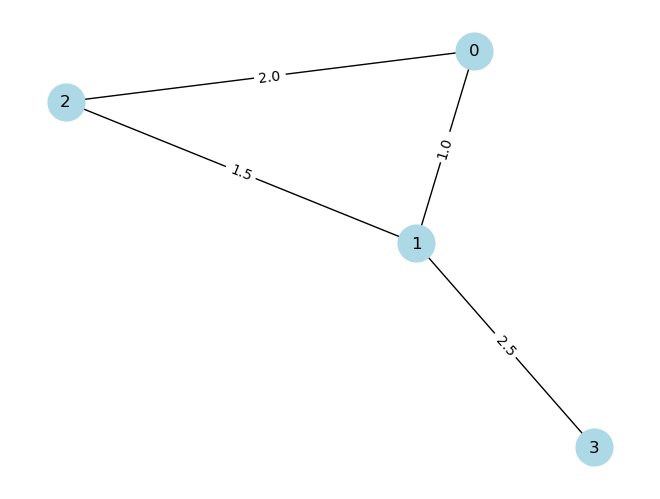

Node logits after Custom GCN forward pass:
tensor([[ 0.0000,  0.0000],
        [ 0.9134, -0.5275],
        [ 1.8280, -0.8404],
        [ 2.7426, -1.1532]], grad_fn=<DivBackward0>)


In [49]:
# test item
import torch
import dgl

# Define node features
node_features = torch.tensor([
    [1, 0, 1],  # Node 0
    [0, 1, 0],  # Node 1
    [1, 1, 0],  # Node 2
    [0, 0, 1]   # Node 3
], dtype=torch.float32)

# Define edges and their capacities
edges = [(0, 1), (0, 2), (1, 2), (1, 3)]
capacities = [1.0, 2.0, 1.5, 2.5]  # Capacities for each edge

# Create the DGL graph
g = dgl.graph(edges)
g.edata['capacity'] = torch.tensor(capacities, dtype=torch.float32)

# Visualize the graph with NetworkX for illustration purposes
import networkx as nx
import matplotlib.pyplot as plt

nx_g = g.to_networkx().to_undirected()
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_size=700, node_color="lightblue")
edge_labels = {edge: f'{cap}' for edge, cap in zip(edges, capacities)}
nx.draw_networkx_edge_labels(nx_g, pos, edge_labels=edge_labels)
plt.show()

import torch.nn as nn
import dgl.function as fn
from dgl.nn import GraphConv

class CustomGCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(CustomGCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.edge_linear = nn.Linear(1, out_feats)

    def forward(self, g, h, e):
        with g.local_scope():
            # Apply linear transformation to node features
            h = self.linear(h)
            g.ndata['h'] = h

            # Apply linear transformation to edge capacities
            e = self.edge_linear(e)
            g.edata['e'] = e

            # Message passing with edge capacities
            g.update_all(message_func=fn.u_add_e('h', 'e', 'm'),
                         reduce_func=fn.mean('m', 'h_new'))

            return g.ndata['h_new']

class CustomGCN(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(CustomGCN, self).__init__()
        self.layer1 = CustomGCNLayer(in_feats, h_feats)
        self.layer2 = CustomGCNLayer(h_feats, out_feats)

    def forward(self, g, node_features, edge_features):
        h = self.layer1(g, node_features, edge_features)
        h = torch.relu(h)
        h = self.layer2(g, h, edge_features)
        return h

# Create the custom GCN model
in_feats = node_features.shape[1]
h_feats = 4  # Number of hidden units
out_feats = 2  # Number of output units (for example, for 2 classes in classification)

model = CustomGCN(in_feats, h_feats, out_feats)

# Convert edge capacities to a tensor for the model
edge_features = g.edata['capacity'].unsqueeze(1)

# Forward pass through the model
logits = model(g, node_features, edge_features)

print("Node logits after Custom GCN forward pass:")
print(logits)


In [50]:
import torch
import dgl

# Define node features (initially simple; you can add more relevant features)
node_features = torch.tensor([
    [1, 0, 1],  # Node 0
    [0, 1, 0],  # Node 1
    [1, 1, 0],  # Node 2
    [0, 0, 1]   # Node 3
], dtype=torch.float32)

# Define edges and their capacities
edges = [(0, 1), (0, 2), (1, 2), (1, 3)]
capacities = [1.0, 2.0, 1.5, 2.5]  # Capacities for each edge

# Create the DGL graph
g = dgl.graph(edges)
g.edata['capacity'] = torch.tensor(capacities, dtype=torch.float32)

import torch.nn as nn
import dgl.function as fn
from dgl.nn import GraphConv

class CustomGCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(CustomGCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.edge_linear = nn.Linear(1, out_feats)

    def forward(self, g, h, e):
        with g.local_scope():
            # Apply linear transformation to node features
            h = self.linear(h)
            g.ndata['h'] = h

            # Apply linear transformation to edge capacities
            e = self.edge_linear(e)
            g.edata['e'] = e

            # Message passing with edge capacities
            g.update_all(message_func=fn.u_add_e('h', 'e', 'm'),
                         reduce_func=fn.mean('m', 'h_new'))

            return g.ndata['h_new']

class CustomGCN(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(CustomGCN, self).__init__()
        self.layer1 = CustomGCNLayer(in_feats, h_feats)
        self.layer2 = CustomGCNLayer(h_feats, out_feats)

    def forward(self, g, node_features, edge_features):
        h = self.layer1(g, node_features, edge_features)
        h = torch.relu(h)
        h = self.layer2(g, h, edge_features)
        return h

# Create the custom GCN model
in_feats = node_features.shape[1]
h_feats = 4  # Number of hidden units
out_feats = 2  # Number of output units (for example, for 2 classes in classification)

model = CustomGCN(in_feats, h_feats, out_feats)

# Convert edge capacities to a tensor for the model
edge_features = g.edata['capacity'].unsqueeze(1)

# Simple training loop (in practice, you'd need a more complex setup with a proper dataset and optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    logits = model(g, node_features, edge_features)

    # Calculate the loss (this is a placeholder; the actual loss function should be based on the min cut)
    # Example: Minimize the sum of the capacities of the edges in the cut
    loss = torch.sum(edge_features)  # Replace with appropriate loss calculation

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn